<a href="https://colab.research.google.com/github/NishaMDev/DeepLearning/blob/main/Assignment%234/DL_Assignment_4b_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PART B PART 1 using PYTORCH - Perform various experiments with weights and biases of hyperparameters in weights and biases in pytorch using sweep library.

# 🚀 Setup

Start out by installing the experiment tracking library and setting up your free W&B account:

1. Install with `!pip install`
2. `import` the library into Python
3. `.login()` so you can log metrics to your projects

If you've never used Weights & Biases before,
the call to `login` will give you a link to sign up for an account.
W&B is free to use for personal and academic projects!

In [13]:
%%capture
!pip install wandb --upgrade

# workaround to fetch MNIST data
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

In [14]:
import wandb

wandb.login()

True

# Step 1️⃣. Define the Sweep

Fundamentally, a Sweep combines a strategy for trying out a bunch of hyperparameter values with the code that evalutes them.
Whether that strategy is as simple as trying every option
or as complex as [BOHB](https://arxiv.org/abs/1807.01774),
Weights & Biases Sweeps have you covered.
You just need to _define your strategy_
in the form of a [configuration](https://docs.wandb.com/sweeps/configuration).

When you're setting up a Sweep in a notebook like this,
that config object is a nested dictionary.
When you run a Sweep via the command line,
the config object is a
[YAML file](https://docs.wandb.com/sweeps/quickstart#2-sweep-config).

Let's walk through the definition of a Sweep config together.
We'll do it slowly, so we get a chance to explain each component.
In a typical Sweep pipeline,
this step would be done in a single assignment.

### 👈 Pick a `method`

The first thing we need to define is the `method`
for choosing new parameter values.

We provide the following search `methods`:
*   **`grid` Search** – Iterate over every combination of hyperparameter values.
Very effective, but can be computationally costly.
*   **`random` Search** – Select each new combination at random according to provided `distribution`s. Surprisingly effective!
*   **`bayes`ian Search** – Create a probabilistic model of metric score as a function of the hyperparameters, and choose parameters with high probability of improving the metric. Works well for small numbers of continuous parameters but scales poorly.

We'll stick with `random`.

In [15]:
sweep_config = {
    'method': 'random'
    }

For `bayes`ian Sweeps,
you also need to tell us a bit about your `metric`.
We need to know its `name`, so we can find it in the model outputs
and we need to know whether your `goal` is to `minimize` it
(e.g. if it's the squared error)
or to `maximize` it
(e.g. if it's the accuracy).

In [16]:
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

If you're not running a bayesian Sweep, you don't have to, but it's not a bad idea to include this in your sweep_config anyway, in case you change your mind later. It's also good reproducibility practice to keep note of things like this, in case you, or someone else, come back to your Sweep in 6 months or 6 years and don't know whether val_G_batch is supposed to be high or low.

### 📃 Name the hyperparameters.


Once you've picked a method to try out new values of the hyperparameters, you need to define what those parameters are.

Most of the time, this step is straightforward: you just give the parameter a name and specify a list of legal values of the parameter.

For example, when we choose the optimizer for our network, there's only a finite number of options. Here we stick with the two most popular choices, adam and sgd. Even for hyperparameters that have potentially infinite options, it usually only makes sense to try out a few select values, as we do here with the hidden layer_size and dropout.

In [17]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
          'values': [0.4, 0.5, 0.6]
        },
    }

sweep_config['parameters'] = parameters_dict

It's often the case that there are hyperparameters that we don't want to vary in this Sweep, but which we still want to set in our sweep_config.

In that case, we just set the value directly:

In [18]:
parameters_dict.update({
    'epochs': {
        'value': 1}
    })

For a grid search, that's all you ever need.

For a random search, all the values of a parameter are equally likely to be chosen on a given run.

If that just won't do, you can instead specify a named distribution, plus its parameters, like the mean mu and standard deviation sigma of a normal distribution.

See more on how to set the distributions of your random variables here.

In [19]:
import math

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms 
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(32),
        'max': math.log(256),
      }
    })

When we're finished, sweep_config is a nested dictionary that specifies exactly which parameters we're interested in trying and what method we're going to use to try them.

In [20]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform',
                               'max': 5.545177444479562,
                               'min': 3.4657359027997265,
                               'q': 1},
                'dropout': {'values': [0.4, 0.5, 0.6]},
                'epochs': {'value': 1},
                'fc_layer_size': {'values': [128, 256, 512]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam', 'sgd']}}}


But that's not all of the configuration options!

For example, we also offer the option to early_terminate your runs with the HyperBand scheduling algorithm. See more here.

You can find a list of all configuration options here and a big collection of examples in YAML format here.

# Step 2️⃣. Initialize the Sweep


Once you've defined the search strategy, it's time to set up something to implement it.

The clockwork taskmaster in charge of our Sweep is known as the Sweep Controller. As each run completes, it will issue a new set of instructions describing a new run to execute. These instructions are picked up by agents who actually perform the runs.

In a typical Sweep, the Controller lives on our machine, while the agents who complete runs live on your machine(s), like in the diagram below. This division of labor makes it super easy to scale up Sweeps by just adding more machines to run agents!


<img src="https://i.imgur.com/zlbw3vQ.png" alt="sweeps-diagram" width="500">

We can wind up a Sweep Controller by calling `wandb.sweep` with the appropriate `sweep_config` and `project` name.

This function returns a `sweep_id` that we will later user to assign agents to this Controller.

> _Side Note_: on the command line, this function is replaced with
```
wandb sweep config.yaml
```
[Learn more about using Sweeps in the command line ➡](https://docs.wandb.com/sweeps/quickstart)

In [21]:
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

Create sweep with ID: a10ivvji
Sweep URL: https://wandb.ai/nishamdev/pytorch-sweeps-demo/sweeps/a10ivvji


# Step 3️⃣. Run the Sweep agent

### 💻 Define Your Training Procedure

Before we can actually execute the sweep,
we need to define the training procedure that uses those values.

In the functions below, we define a simple fully-connected neural network in PyTorch, and add the following `wandb` tools to log model metrics, visualize performance and output and track our experiments:
* [**`wandb.init()`**](https://docs.wandb.com/library/init) – Initialize a new W&B Run. Each Run is a single execution of the training function.
* [**`wandb.config`**](https://docs.wandb.com/library/config) – Save all your hyperparameters in a configuration object so they can be logged. Read more about how to use `wandb.config` [here](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-config/Configs_in_W%26B.ipynb).
* [**`wandb.log()`**](https://docs.wandb.com/library/log) – log model behavior to W&B. Here, we just log the performance; see [this Colab](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-log/Log_(Almost)_Anything_with_W%26B_Media.ipynb) for all the other rich media that can be logged with `wandb.log`.

For more details on instrumenting W&B with PyTorch, see [this Colab](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Simple_PyTorch_Integration.ipynb).

In [22]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        loader = build_dataset(config.batch_size)
        network = build_network(config.fc_layer_size, config.dropout)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)

        for epoch in range(config.epochs):
            avg_loss = train_epoch(network, loader, optimizer)
            wandb.log({"loss": avg_loss, "epoch": epoch}) 

This cell defines the four pieces of our training procedure:
`build_dataset`, `build_network`, `build_optimizer`, and `train_epoch`.

All of these are a standard part of a basic PyTorch pipeline,
and their implementation is unaffected by the use of W&B,
so we won't comment on them.

In [23]:
def build_dataset(batch_size):
   
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))])
    # download MNIST training dataset
    dataset = datasets.MNIST(".", train=True, download=True,
                             transform=transform)
    sub_dataset = torch.utils.data.Subset(
        dataset, indices=range(0, len(dataset), 5))
    loader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size)

    return loader


def build_network(fc_layer_size, dropout):
    network = nn.Sequential(  # fully-connected, single hidden layer
        nn.Flatten(),
        nn.Linear(784, fc_layer_size), nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layer_size, 10),
        nn.LogSoftmax(dim=1))

    return network.to(device)
        

def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer


def train_epoch(network, loader, optimizer):
    cumu_loss = 0
    for _, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ➡ Forward pass
        loss = F.nll_loss(network(data), target)
        cumu_loss += loss.item()

        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()

        wandb.log({"batch loss": loss.item()})

    return cumu_loss / len(loader)

Now, we're ready to start sweeping! 🧹🧹🧹

Sweep Controllers, like the one we made by running `wandb.sweep`,
sit waiting for someone to ask them for a `config` to try out.

That someone is an `agent`, and they are created with `wandb.agent`.
To get going, the agent just needs to know
1. which Sweep it's a part of (`sweep_id`)
2. which function it's supposed to run (here, `train`)
3. (optionally) how many configs to ask the Controller for (`count`)

FYI, you can start multiple `agent`s with the same `sweep_id`
on different compute resources,
and the Controller will ensure that they work together
according to the strategy laid out in the `sweep_config`.
This makes it trivially easy to scale your Sweeps across as many nodes as you can get ahold of!

> _Side Note:_ on the command line, this function is replaced with
```
wandb agent sweep_id
```
[Learn more about using Sweeps in the command line ➡](https://docs.wandb.com/sweeps/quickstart)

The cell below will launch an `agent` that runs `train` 5 times,
usingly the randomly-generated hyperparameter values returned by the Sweep Controller. Execution takes under 5 minutes.

In [24]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: pikx291g with config:
wandb: 	batch_size: 118
wandb: 	dropout: 0.6
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.06661473940441541
wandb: 	optimizer: sgd


batch loss,█▇▄▃▂▃▂▃▂▃▂▃▂▂▃▃▃▂▃▂▂▂▁▂▂▁▂▂▁▂▂▂▁▂▁▂▂▁▁▂
epoch,▁
loss,▁
batch loss,0.52445
epoch,0
loss,0.65889


wandb: Agent Starting Run: 8e4ambm0 with config:
wandb: 	batch_size: 149
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.027383144893713775
wandb: 	optimizer: adam


batch loss,▂█▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.886
epoch,0
loss,1.59329


wandb: Agent Starting Run: o2c1rp5z with config:
wandb: 	batch_size: 154
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.04471828080671778
wandb: 	optimizer: sgd


batch loss,██▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▂▂▂▁▂▁▂▁▂▁▂▂▂▂▁▂▁▂▁▁▂
epoch,▁
loss,▁
batch loss,0.36188
epoch,0
loss,0.6179


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lv0wlg4p with config:
wandb: 	batch_size: 123
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.02388463301932775
wandb: 	optimizer: adam


batch loss,▂█▆▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.94959
epoch,0
loss,1.44652


wandb: Agent Starting Run: eelcxwui with config:
wandb: 	batch_size: 177
wandb: 	dropout: 0.6
wandb: 	epochs: 1
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.07313296024526263
wandb: 	optimizer: sgd


batch loss,█▇▆▅▄▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▂▂▂▂▂▂▂▁▂▁▂
epoch,▁
loss,▁
batch loss,0.52981
epoch,0
loss,0.76635


# 👀 Visualize Sweep Results



## 🔀 Parallel Coordinates Plot
This plot maps hyperparameter values to model metrics. It’s useful for honing in on combinations of hyperparameters that led to the best model performance.

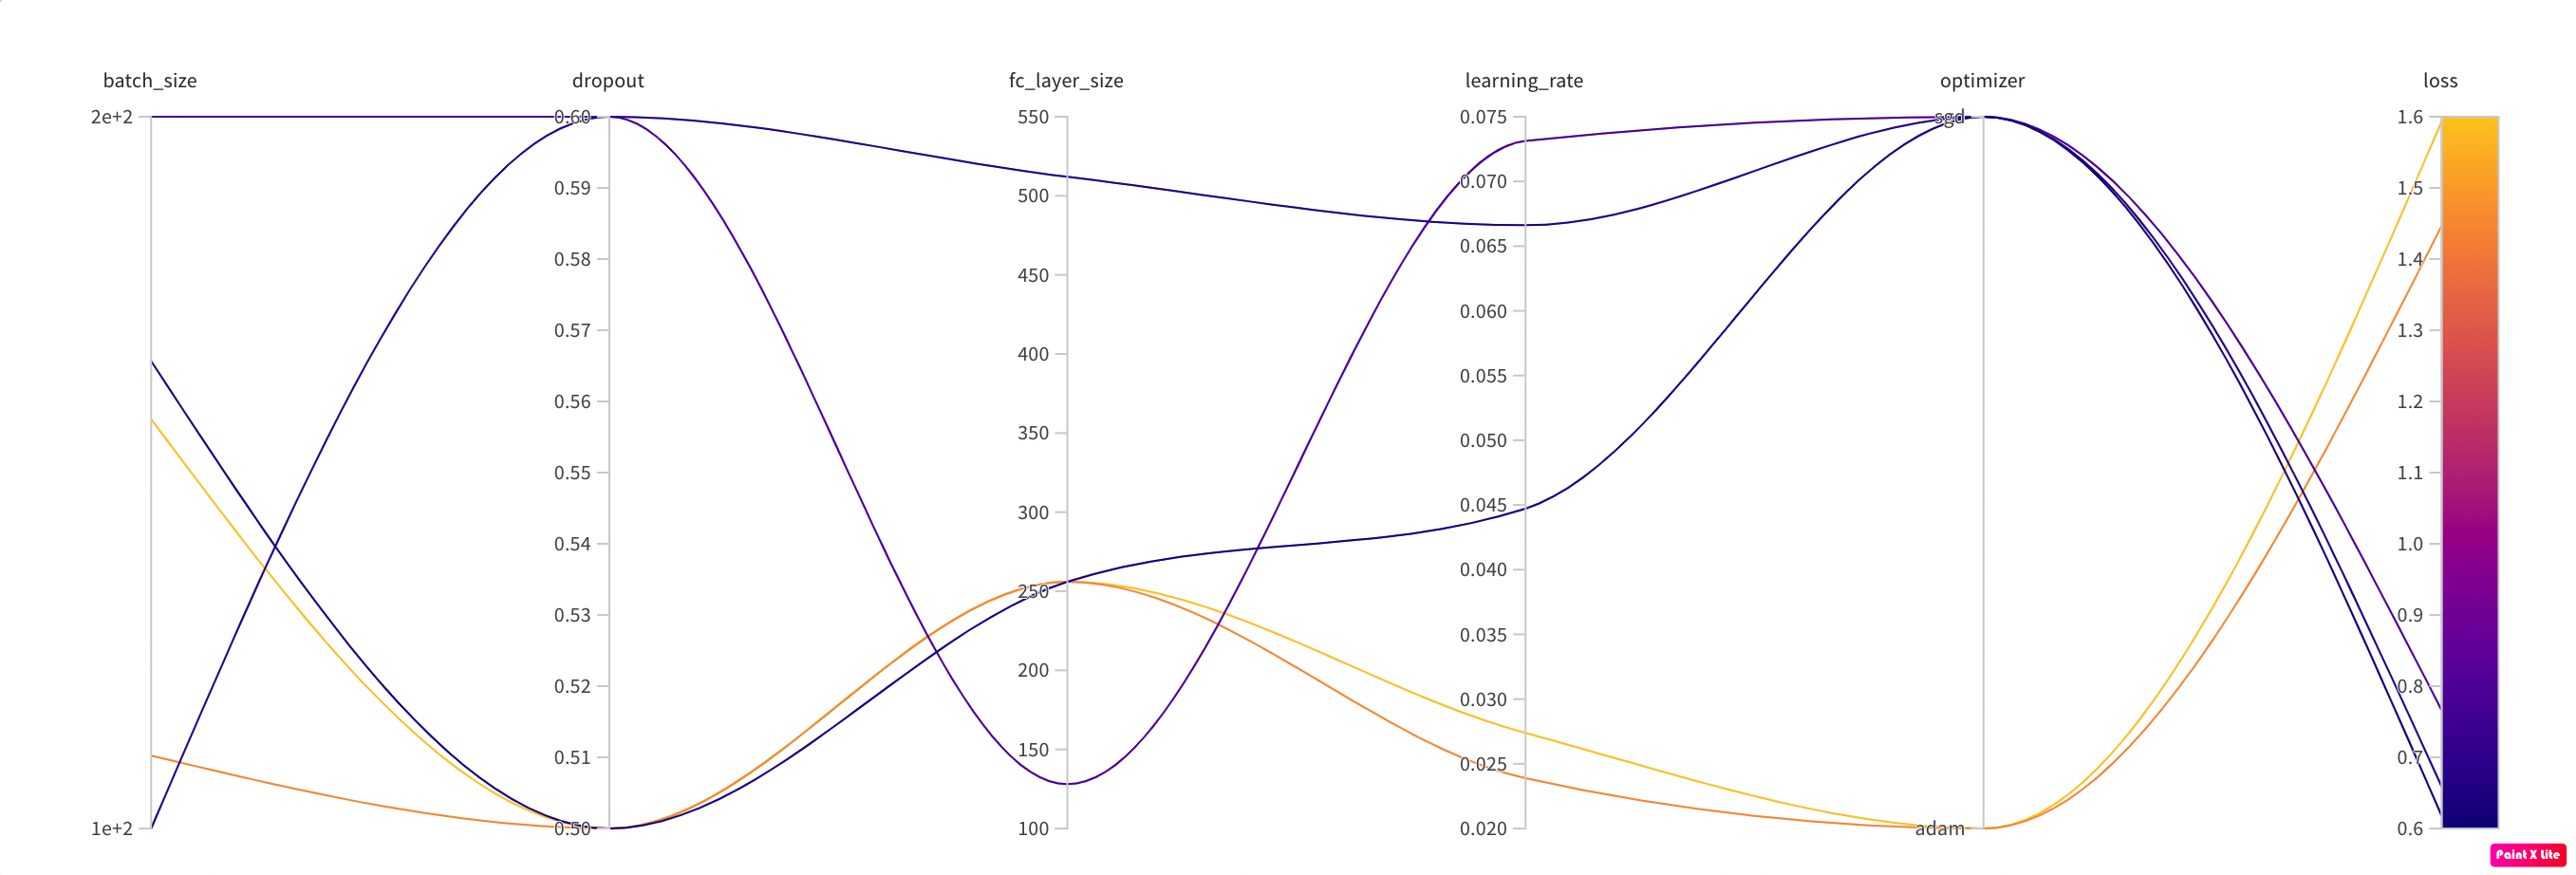

## 📊 Hyperparameter Importance Plot
The hyperparameter importance plot surfaces which hyperparameters were the best predictors of your metrics.
We report feature importance (from a random forest model) and correlation (implicitly a linear model).

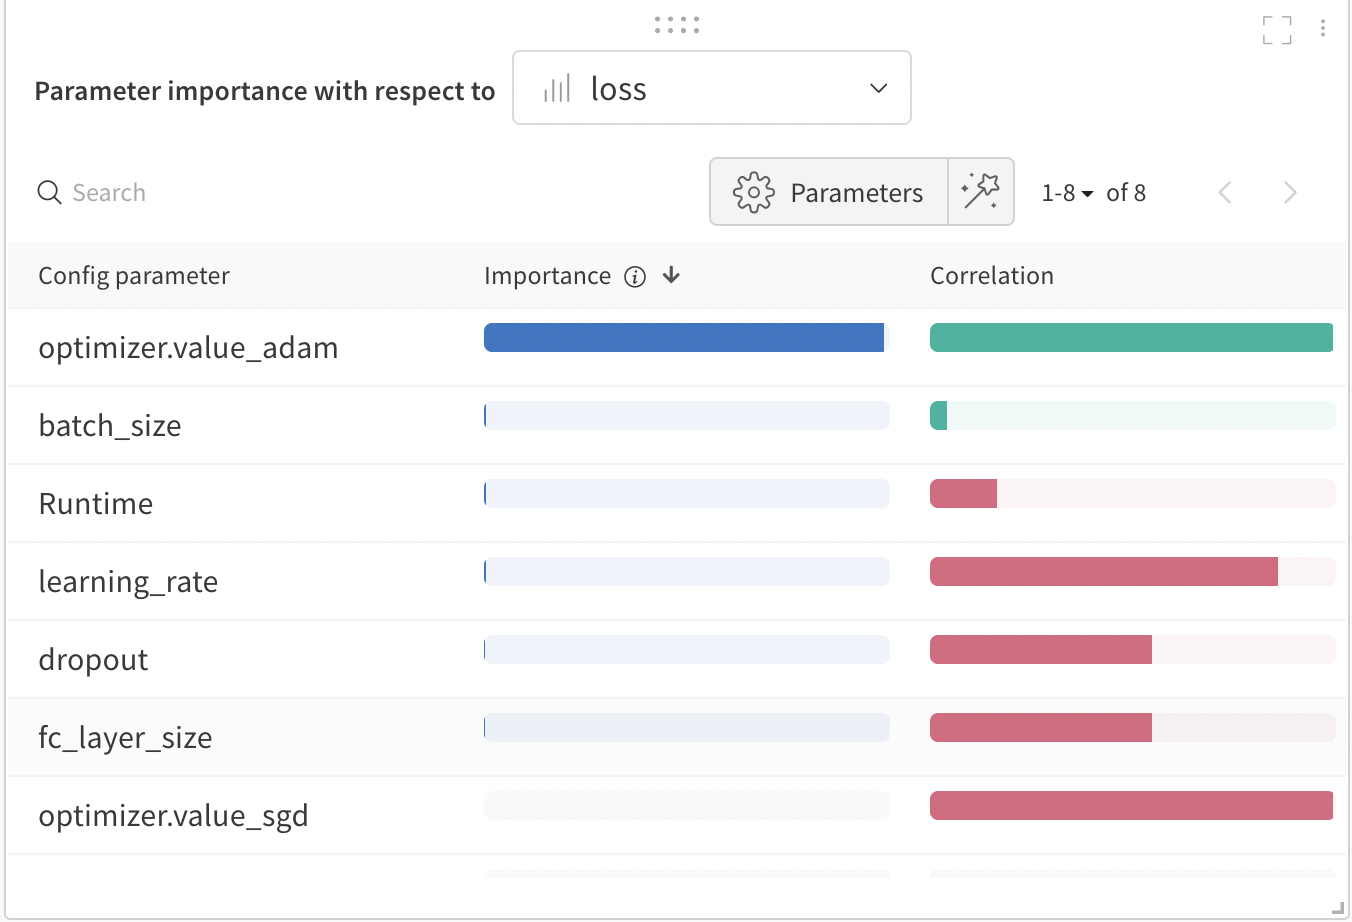

These visualizations can help you save both time and resources running expensive hyperparameter optimizations by honing in on the parameters (and value ranges) that are the most important, and thereby worthy of further exploration.


# 🧤 Get your hands dirty with sweeps

We created a simple training script and [a few flavors of sweep configs](https://github.com/wandb/examples/tree/master/examples/keras/keras-cnn-fashion) for you to play with. We highly encourage you to give these a try.

That repo also has examples to help you try more advanced sweep features like [Bayesian Hyperband](https://app.wandb.ai/wandb/examples-keras-cnn-fashion/sweeps/us0ifmrf?workspace=user-lavanyashukla), and [Hyperopt](https://app.wandb.ai/wandb/examples-keras-cnn-fashion/sweeps/xbs2wm5e?workspace=user-lavanyashukla).